In [1]:
library(tidyr)
library(dplyr)
library(lubridate)
library(recipes)
library(xgboost)
library(rBayesianOptimization)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Attaching package: 'lubridate'

The following object is masked from 'package:base':

    date

Loading required package: broom

Attaching package: 'recipes'

The following object is masked from 'package:stats':

    step


Attaching package: 'xgboost'

The following object is masked from 'package:dplyr':

    slice



### Explore the dataset to identify any potential anomalies.

Read the file into a data frame and remove all rows containing NA values. Also remove CustomerID, as we cannot learn anything from it.

In [38]:
df_raw <- read.csv("../data/cust_churn.csv", fileEncoding = "UTF-8-BOM", stringsAsFactors = F) %>% na.omit() %>% select(-customerID) %>% mutate(Churn = as.numeric(Churn == "Yes"))
df_data <- df_raw

If any of the categorical variables are distributed disproportionately, it could affect the usefulness of the variable. We would like to see a distribution in the sample
that closely resembles the population.

In [6]:
table(df_data$gender)


Female   Male 
  3483   3549 

In [7]:
for(c in colnames(df_data)) 
{
    if(class(df_data[,c]) == "character") {
        paste(print(c),print(table(df_data[,c])))
    }
}

[1] "gender"

Female   Male 
  3483   3549 
[1] "Partner"

  No  Yes 
3639 3393 
[1] "Dependents"

  No  Yes 
4933 2099 
[1] "PhoneService"

  No  Yes 
 680 6352 
[1] "MultipleLines"

              No No phone service              Yes 
            3385              680             2967 
[1] "InternetService"

        DSL Fiber optic          No 
       2416        3096        1520 
[1] "OnlineSecurity"

                 No No internet service                 Yes 
               3497                1520                2015 
[1] "OnlineBackup"

                 No No internet service                 Yes 
               3087                1520                2425 
[1] "DeviceProtection"

                 No No internet service                 Yes 
               3094                1520                2418 
[1] "TechSupport"

                 No No internet service                 Yes 
               3472                1520                2040 
[1] "StreamingTV"

                 No No 

The categorical data appears to be suitably distributed for an analysis.

## Discretize the numeric variables so model coefficients are on the same scale.
The *smbinning* package performs recursive partitioning on the numeric variables using WOE and IV as metrics.

In [8]:
#install.packages("smbinning")
library(smbinning)

Loading required package: sqldf
Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite
Loading required package: partykit
Loading required package: grid
Loading required package: libcoin
Loading required package: mvtnorm
Loading required package: Formula


In [39]:
result=smbinning(df=df_data,y="Churn",x="tenure",p=0.05) 
result$ivtable

Cutpoint,CntRec,CntGood,CntBad,CntCumRec,CntCumGood,CntCumBad,PctRec,GoodRate,BadRate,Odds,LnOdds,WoE,IV
<= 1,613,380,233,613,380,233,0.0872,0.6199,0.3801,1.6309,0.4891,1.5052,0.2381
<= 5,747,364,383,1360,744,616,0.1062,0.4873,0.5127,0.9504,-0.0509,0.9652,0.1164
<= 16,1179,420,759,2539,1164,1375,0.1677,0.3562,0.6438,0.5534,-0.5917,0.4244,0.0330
<= 22,481,131,350,3020,1295,1725,0.0684,0.2723,0.7277,0.3743,-0.9827,0.0334,0.0001
<= 49,1839,376,1463,4859,1671,3188,0.2615,0.2045,0.7955,0.2570,-1.3587,-0.3425,0.0281
<= 59,690,99,591,5549,1770,3779,0.0981,0.1435,0.8565,0.1675,-1.7867,-0.7706,0.0474
<= 70,951,87,864,6500,1857,4643,0.1352,0.0915,0.9085,0.1007,-2.2957,-1.2796,0.1546
> 70,532,12,520,7032,1869,5163,0.0757,0.0226,0.9774,0.0231,-3.7689,-2.7528,0.2596
Missing,0,0,0,7032,1869,5163,0.0000,NaN,NaN,NaN,NaN,NaN,NaN
Total,7032,1869,5163,NA,NA,NA,1.0000,0.2658,0.7342,0.3620,-1.0161,0.0000,0.8773


In [40]:
df_data$TenureCat <- cut(df_data$tenure, breaks=c(0,result$cuts,Inf), include.lowest = F)
df_data <- df_data %>% select(-tenure)

In [41]:
result=smbinning(df=df_data,y="Churn",x="MonthlyCharges",p=0.05) 
result$ivtable

Cutpoint,CntRec,CntGood,CntBad,CntCumRec,CntCumGood,CntCumBad,PctRec,GoodRate,BadRate,Odds,LnOdds,WoE,IV
<= 26.9,1600,148,1452,1600,148,1452,0.2275,0.0925,0.9075,0.1019,-2.2835,-1.2674,0.2561
<= 55.95,1119,318,801,2719,466,2253,0.1591,0.2842,0.7158,0.3970,-0.9238,0.0923,0.0014
<= 68.8,563,66,497,3282,532,2750,0.0801,0.1172,0.8828,0.1328,-2.0189,-1.0028,0.0611
<= 106.75,3380,1279,2101,6662,1811,4851,0.4807,0.3784,0.6216,0.6088,-0.4963,0.5198,0.1442
> 106.75,370,58,312,7032,1869,5163,0.0526,0.1568,0.8432,0.1859,-1.6826,-0.6664,0.0196
Missing,0,0,0,7032,1869,5163,0.0000,NaN,NaN,NaN,NaN,NaN,NaN
Total,7032,1869,5163,NA,NA,NA,1.0000,0.2658,0.7342,0.3620,-1.0161,0.0000,0.4824


In [42]:
df_data$MonthlyChargesCat <- cut(df_data$MonthlyCharges, breaks=c(0,result$cuts,Inf), include.lowest = F) 
df_data <- df_data %>% select(-MonthlyCharges)

In [43]:
result=smbinning(df=df_data,y="Churn",x="TotalCharges",p=0.05) 
result$ivtable

Cutpoint,CntRec,CntGood,CntBad,CntCumRec,CntCumGood,CntCumBad,PctRec,GoodRate,BadRate,Odds,LnOdds,WoE,IV
<= 198,1173,574,599,1173,574,599,0.1668,0.4893,0.5107,0.9583,-0.0426,0.9735,0.1860
<= 3233.85,3805,988,2817,4978,1562,3416,0.5411,0.2597,0.7403,0.3507,-1.0477,-0.0316,0.0005
<= 5643.4,1195,201,994,6173,1763,4410,0.1699,0.1682,0.8318,0.2022,-1.5984,-0.5823,0.0495
> 5643.4,859,106,753,7032,1869,5163,0.1222,0.1234,0.8766,0.1408,-1.9606,-0.9445,0.0842
Missing,0,0,0,7032,1869,5163,0.0000,NaN,NaN,NaN,NaN,NaN,NaN
Total,7032,1869,5163,NA,NA,NA,1.0000,0.2658,0.7342,0.3620,-1.0161,0.0000,0.3202


In [44]:
df_data$TotalChargesCat <- cut(df_data$TotalCharges, breaks=c(0,result$cuts,Inf), include.lowest = F) 
df_data <- df_data %>% select(-TotalCharges)

### Split into training and validation sets.

In [45]:
library(rsample)
set.seed(12345)

In [46]:
split_set <- initial_split(df_data, prop = 0.75)

In [47]:
df_train <- training(split_set)
df_test <- testing(split_set)

### Scale and center all numeric variables. Create dummy variables for categories.

In [48]:
library(recipes)

In [49]:
recipe_obj <- recipe(Churn ~ ., data = df_train) %>%
    step_dummy(all_nominal(), -all_outcomes()) %>%
    step_center(all_predictors(), -all_outcomes()) %>%
    step_scale(all_predictors(), -all_outcomes()) %>%
    prep(data = df_train)

In [50]:
df_train_x <- bake(recipe_obj, newdata=df_train, -all_outcomes())
df_test_x <- bake(recipe_obj, newdata=df_test, -all_outcomes())

In [51]:
vec_train_y <- df_train$Churn
vec_test_y <- df_test$Churn

In [52]:
write.csv(df_train_x, "../data/df_train_x.csv")
write.csv(df_test_x, "../data/df_test_x.csv")
write.csv(vec_train_y, "../data/vec_train_y.csv")
write.csv(vec_test_y, "../data/vec_test_y.csv")


In [53]:
library(corrr)
library(tidyquant)

In [54]:
corrr_analysis <- df_train_x %>%
    mutate(Churn = vec_train_y) %>%
    correlate() %>%
    focus(Churn) %>%
    rename(feature = rowname) %>%
    arrange(abs(Churn)) %>%
    mutate(feature = as_factor(feature)) 
write.csv(corrr_analysis, "../data/feature_importance.csv")


Correlation method: 'pearson'
Missing treated using: 'pairwise.complete.obs'

Warning message in file(file, ifelse(append, "a", "w")):
"cannot open file '../data/feature_importance.csv': Permission denied"

ERROR: Error in file(file, ifelse(append, "a", "w")): cannot open the connection


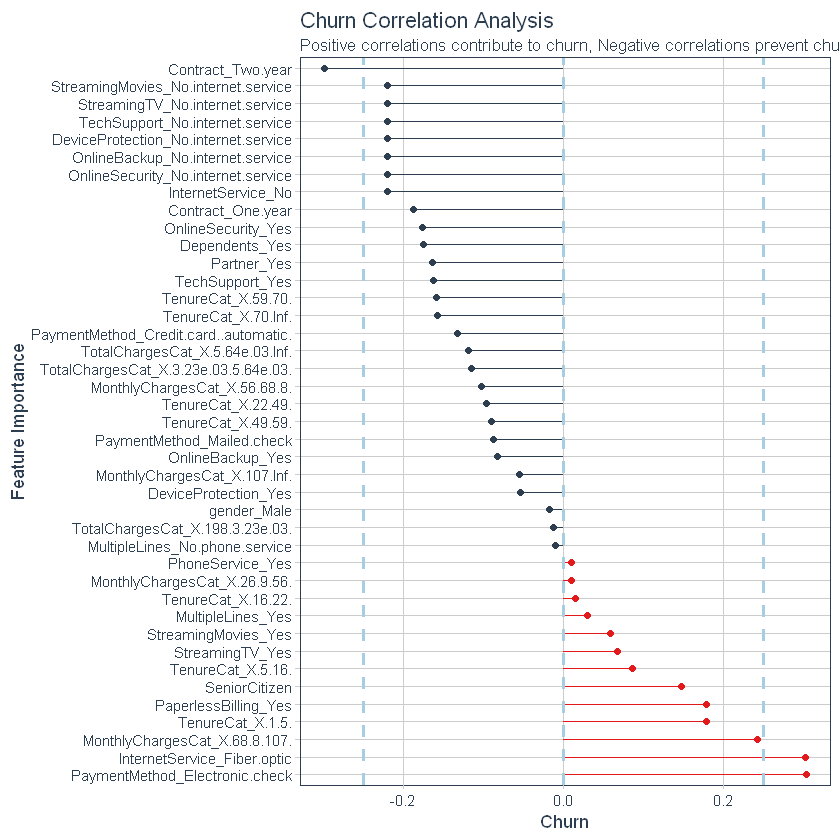

In [55]:
# Correlation visualization
corrr_analysis %>%
    ggplot(aes(x = Churn, y = fct_reorder(feature, desc(Churn)))) +
    geom_point() +
    # Positive Correlations - Contribute to churn
    geom_segment(aes(xend = 0, yend = feature), 
                 color = palette_light()[[2]], 
                 data = corrr_analysis %>% filter(Churn > 0)) +
    geom_point(color = palette_light()[[2]], 
               data = corrr_analysis %>% filter(Churn > 0)) +
    # Negative Correlations - Prevent churn
    geom_segment(aes(xend = 0, yend = feature), 
                 color = palette_light()[[1]], 
                 data = corrr_analysis %>% filter(Churn < 0)) +
    geom_point(color = palette_light()[[1]], 
               data = corrr_analysis %>% filter(Churn < 0)) +
    # Vertical lines
    geom_vline(xintercept = 0, color = palette_light()[[5]], size = 1, linetype = 2) +
    geom_vline(xintercept = -0.25, color = palette_light()[[5]], size = 1, linetype = 2) +
    geom_vline(xintercept = 0.25, color = palette_light()[[5]], size = 1, linetype = 2) +
    # Aesthetics
    theme_tq() +
    labs(title = "Churn Correlation Analysis",
         subtitle = "Positive correlations contribute to churn, Negative correlations prevent churn",
         y = "Feature Importance")

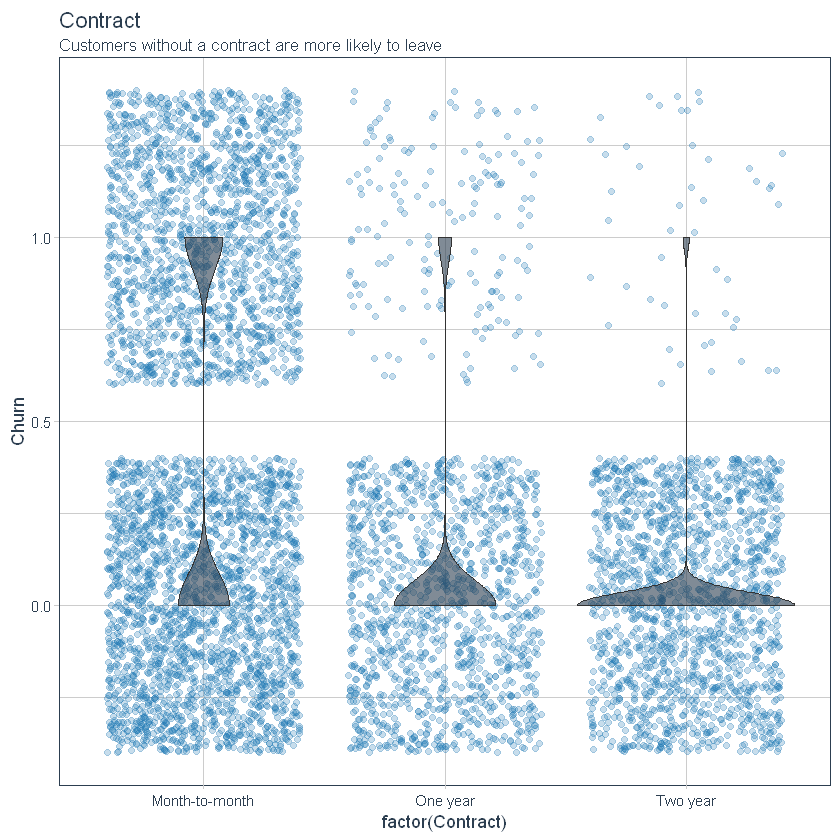

In [80]:
# Tenure
df_data %>%
ggplot(aes(x = factor(Contract), y = Churn)) +
geom_jitter(alpha = 0.25, color = palette_light()[[6]]) +
geom_violin(alpha = 0.6, fill = palette_light()[[1]]) +
theme_tq() +
labs(
title = "Contract",
subtitle = "Customers without a contract are more likely to leave"
)

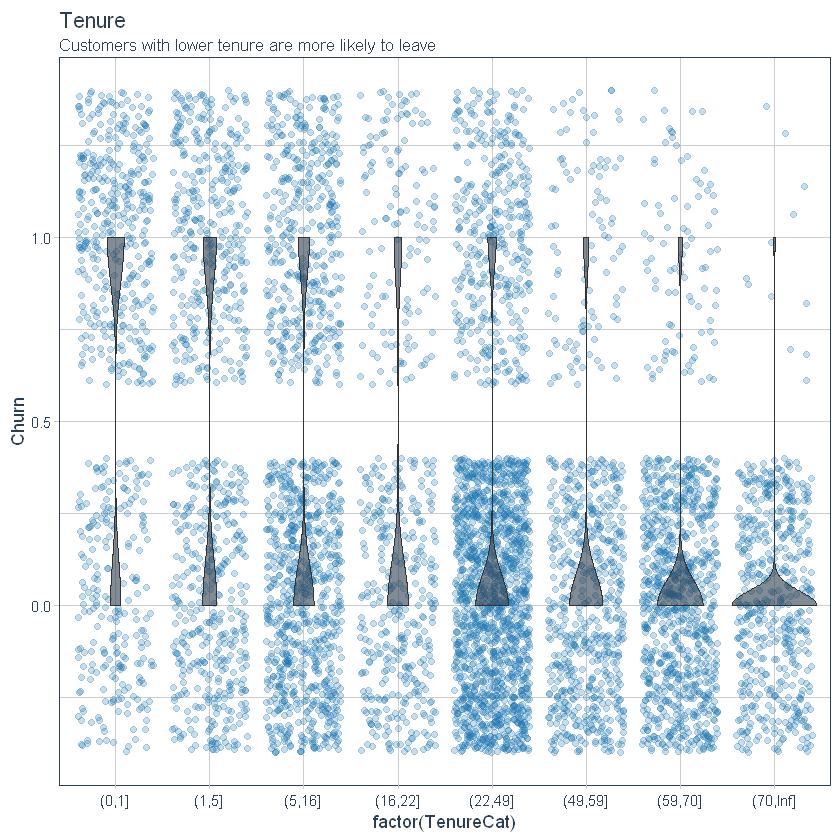

In [60]:
# Tenure
df_data %>%
ggplot(aes(x = factor(TenureCat), y = Churn)) +
geom_jitter(alpha = 0.25, color = palette_light()[[6]]) +
geom_violin(alpha = 0.6, fill = palette_light()[[1]]) +
theme_tq() +
labs(
title = "Tenure",
subtitle = "Customers with lower tenure are more likely to leave"
)

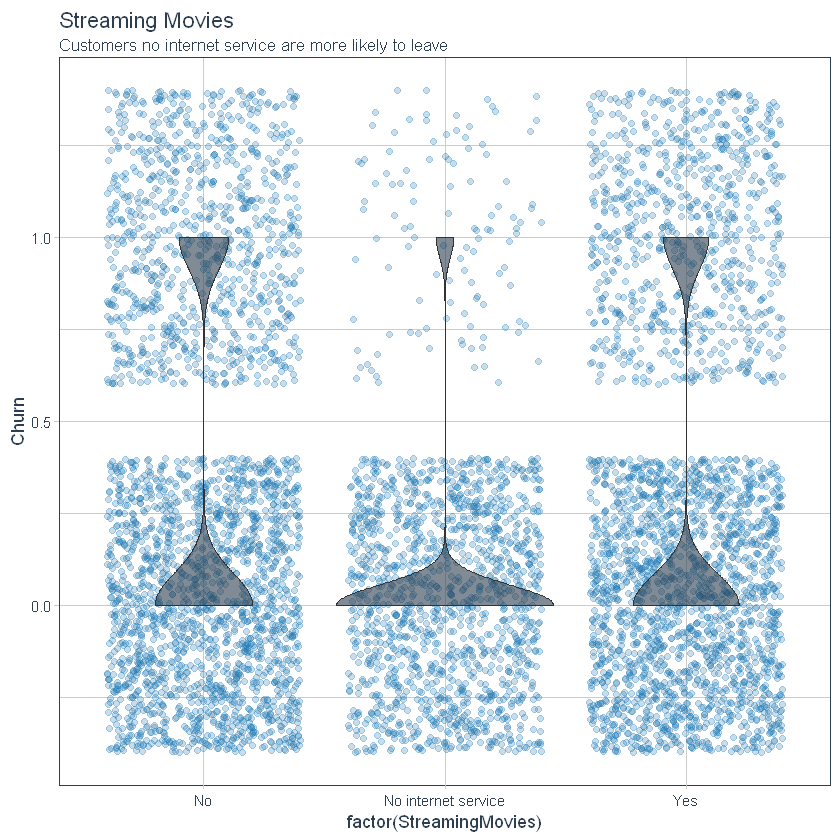

In [68]:
# Tenure
df_data %>%
ggplot(aes(x = factor(StreamingMovies), y = Churn)) +
geom_jitter(alpha = 0.25, color = palette_light()[[6]]) +
geom_violin(alpha = 0.6, fill = palette_light()[[1]]) +
theme_tq() +
labs(
title = "Streaming Movies",
subtitle = "Customers no internet service are more likely to leave"
)

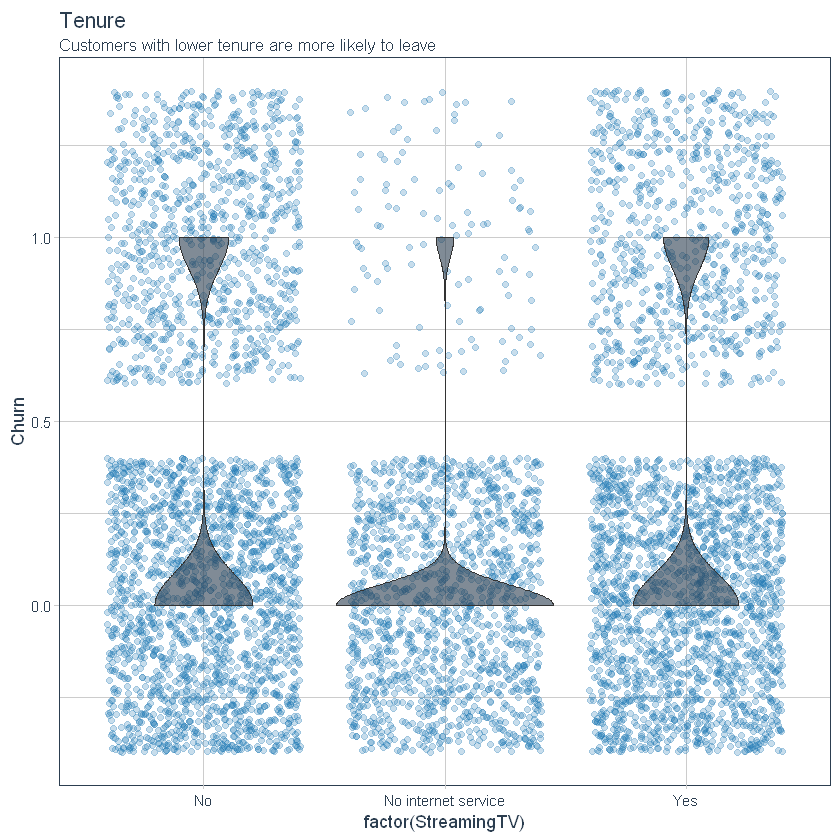

In [62]:
# Tenure
df_data %>%
ggplot(aes(x = factor(StreamingTV), y = Churn)) +
geom_jitter(alpha = 0.25, color = palette_light()[[6]]) +
geom_violin(alpha = 0.6, fill = palette_light()[[1]]) +
theme_tq() +
labs(
title = "Tenure",
subtitle = "Customers with lower tenure are more likely to leave"
)

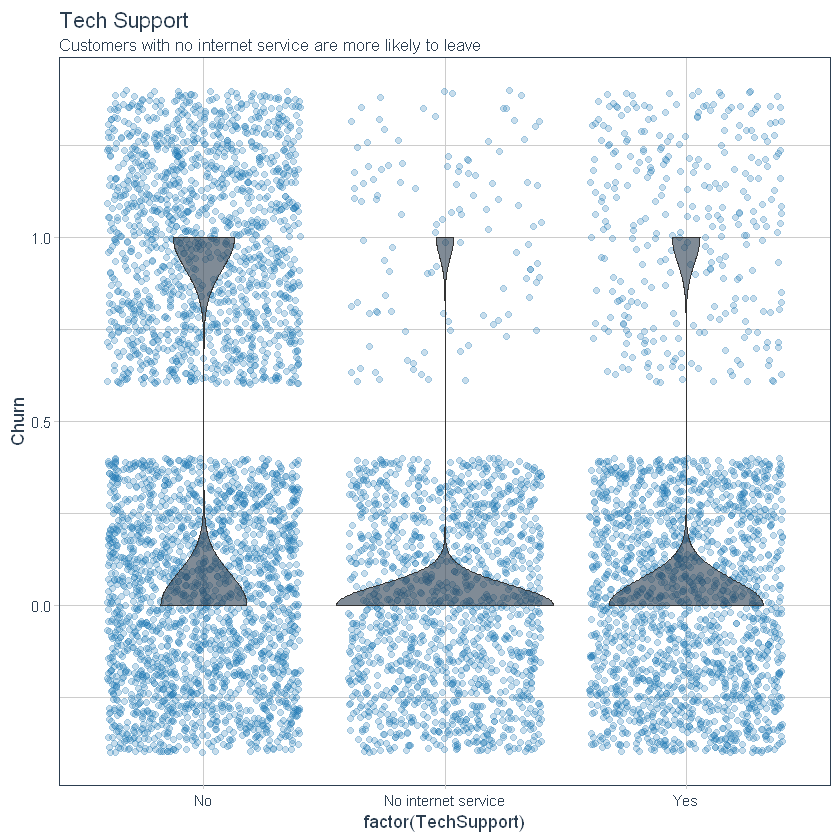

In [69]:
# Tenure
df_data %>%
ggplot(aes(x = factor(TechSupport), y = Churn)) +
geom_jitter(alpha = 0.25, color = palette_light()[[6]]) +
geom_violin(alpha = 0.6, fill = palette_light()[[1]]) +
theme_tq() +
labs(
title = "Tech Support",
subtitle = "Customers with no internet service are more likely to leave"
)

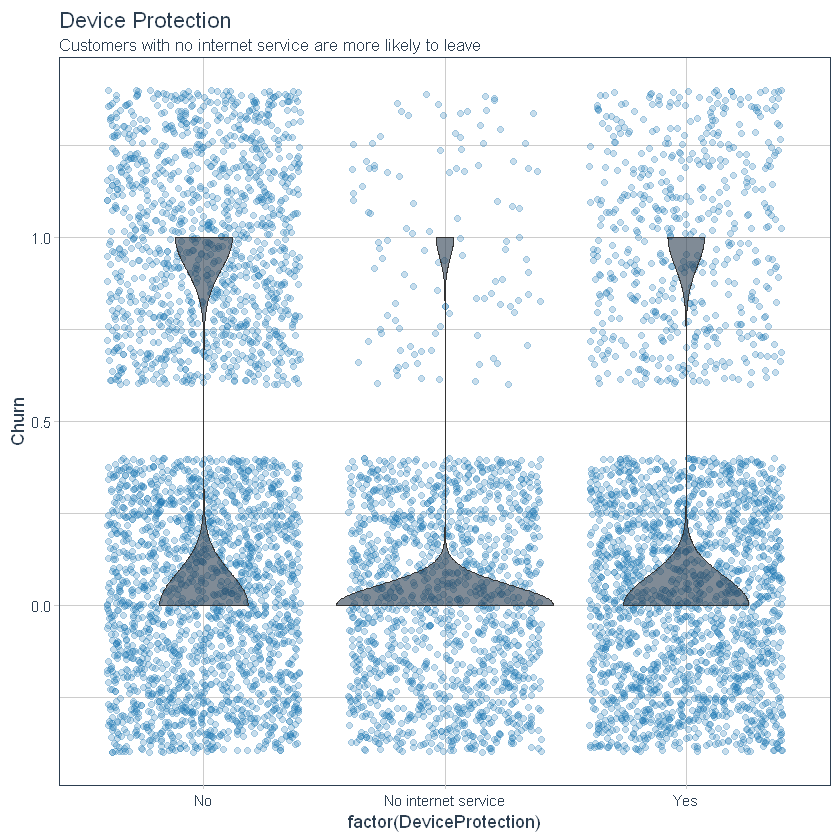

In [70]:
# Tenure
df_data %>%
ggplot(aes(x = factor(DeviceProtection), y = Churn)) +
geom_jitter(alpha = 0.25, color = palette_light()[[6]]) +
geom_violin(alpha = 0.6, fill = palette_light()[[1]]) +
theme_tq() +
labs(
title = "Device Protection",
subtitle = "Customers with no internet service are more likely to leave"
)

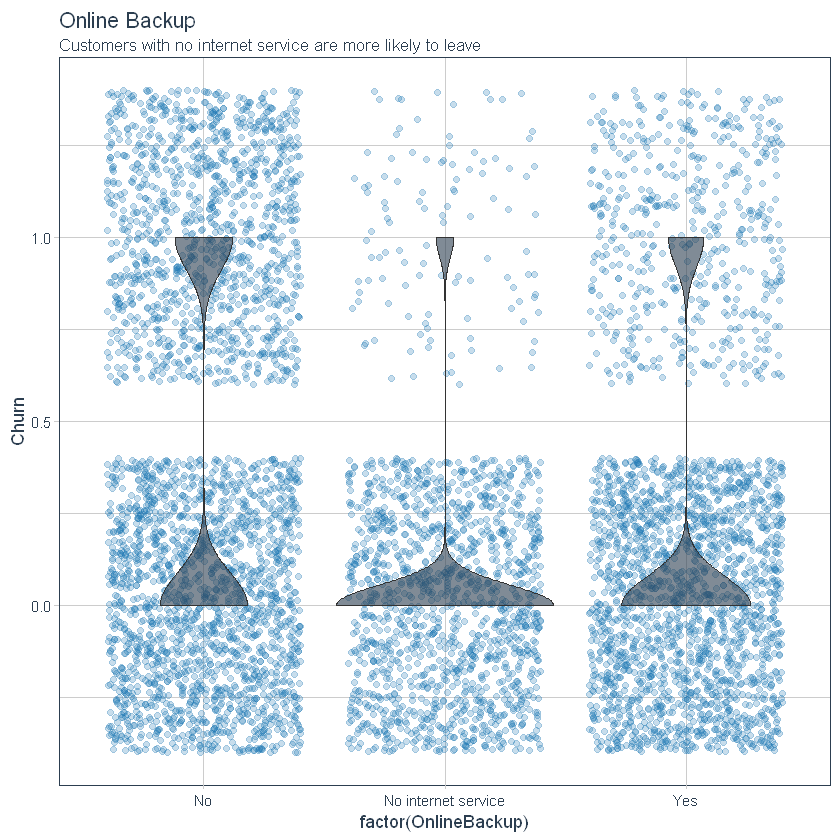

In [71]:
# Tenure
df_data %>%
ggplot(aes(x = factor(OnlineBackup), y = Churn)) +
geom_jitter(alpha = 0.25, color = palette_light()[[6]]) +
geom_violin(alpha = 0.6, fill = palette_light()[[1]]) +
theme_tq() +
labs(
title = "Online Backup",
subtitle = "Customers with no internet service are more likely to leave"
)

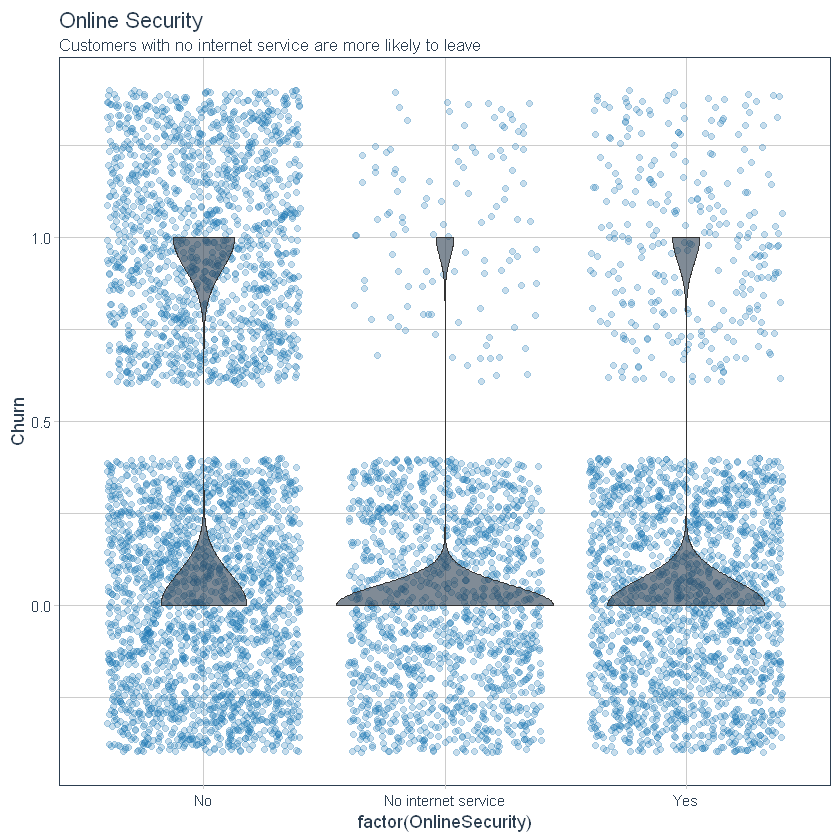

In [73]:
# Tenure
df_data %>%
ggplot(aes(x = factor(OnlineSecurity), y = Churn)) +
geom_jitter(alpha = 0.25, color = palette_light()[[6]]) +
geom_violin(alpha = 0.6, fill = palette_light()[[1]]) +
theme_tq() +
labs(
title = "Online Security",
subtitle = "Customers with no internet service are more likely to leave"
)

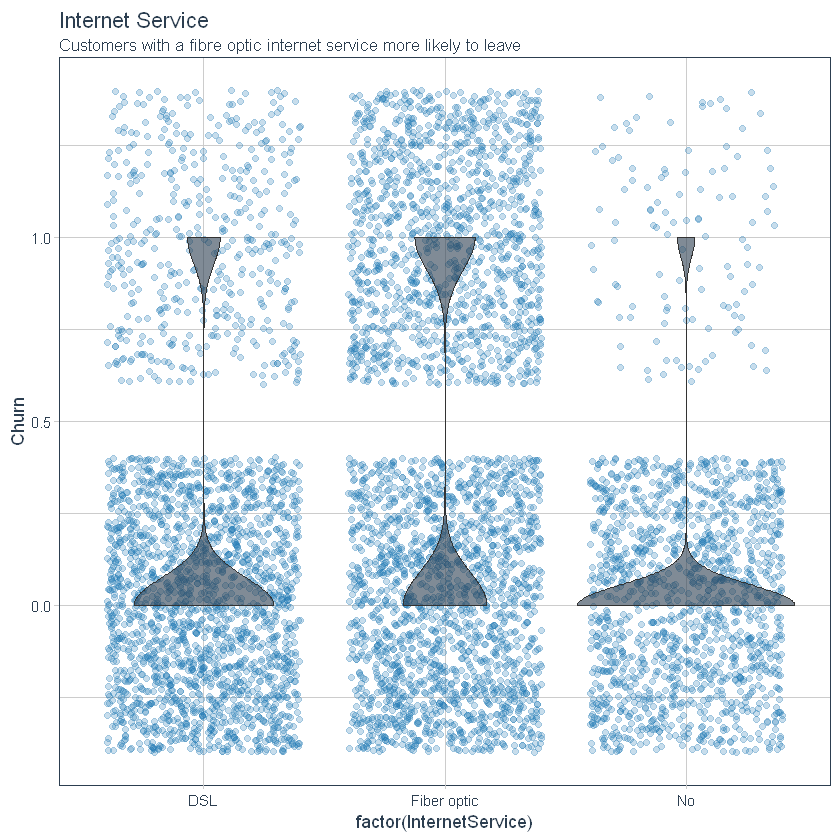

In [83]:
# Tenure
df_data %>%
ggplot(aes(x = factor(InternetService), y = Churn)) +
geom_jitter(alpha = 0.25, color = palette_light()[[6]]) +
geom_violin(alpha = 0.6, fill = palette_light()[[1]]) +
theme_tq() +
labs(
title = "Internet Service",
subtitle = "Customers with a fibre optic internet service more likely to leave"
)

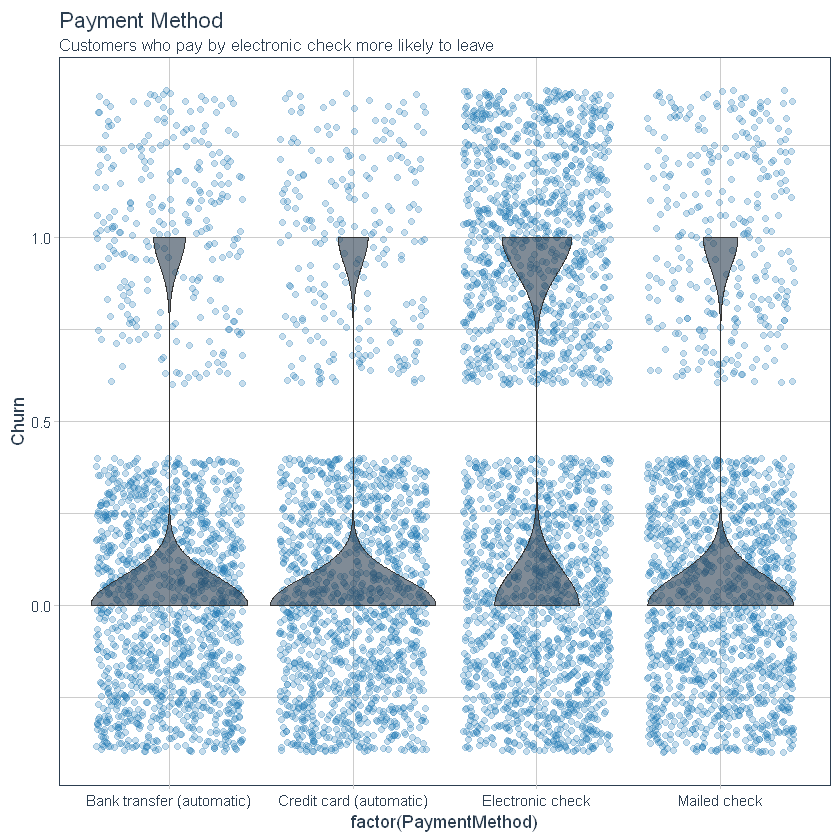

In [82]:
# Tenure
df_data %>%
ggplot(aes(x = factor(PaymentMethod), y = Churn)) +
geom_jitter(alpha = 0.25, color = palette_light()[[6]]) +
geom_violin(alpha = 0.6, fill = palette_light()[[1]]) +
theme_tq() +
labs(
title = "Payment Method",
subtitle = "Customers who pay by electronic check more likely to leave"
)

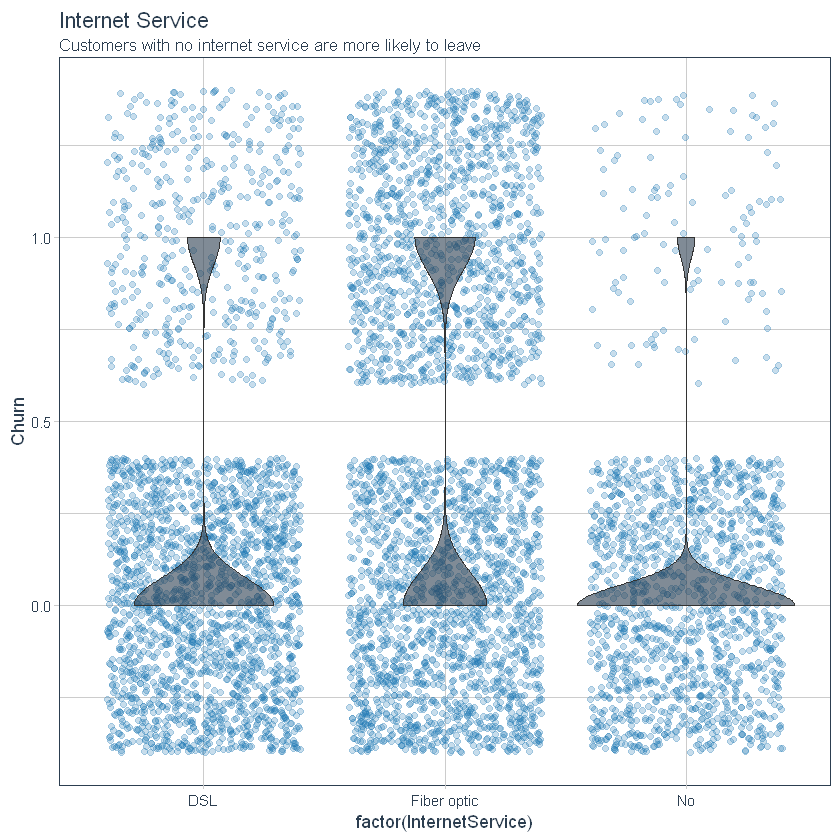

In [75]:
# Tenure
df_data %>%
ggplot(aes(x = factor(InternetService), y = Churn)) +
geom_jitter(alpha = 0.25, color = palette_light()[[6]]) +
geom_violin(alpha = 0.6, fill = palette_light()[[1]]) +
theme_tq() +
labs(
title = "Internet Service",
subtitle = "Customers with no internet service are more likely to leave"
)